#Import libraries

In [1]:
# Standard libraries
import math
import time
import random
from typing import List, Tuple, Optional, Union

# Numerical and GPU computation libraries
import numpy as np
from numba import cuda, jit, prange, float32

# Image processing libraries
import cv2
from PIL import Image

# Plotting libraries
import matplotlib.pyplot as plt

#Kernel definitions

##Computation

In [7]:
class Compute:
    @staticmethod
    @cuda.jit
    def _calculate_distances_gpu(X, centroids, distances):

        i, j = cuda.grid(2)  # Thread indices

        if i < X.shape[0] and j < centroids.shape[0]:  # Ensure we are within bounds
            dist = 0.0
            for d in range(X.shape[1]):
                diff = X[i, d] - centroids[j, d]
                dist += diff * diff

            # distances[i, j] = dist    # Store the distance
            distances[i, j] = math.sqrt(dist)

        # # Ensure distances are not too small
        # distances[i, j] = max(distances[i, j], 1e-6)

    @staticmethod
    @cuda.jit
    def _calculate_centroids_gpu(X, labels, centroids, n_points_per_cluster):

        i = cuda.grid(1)    # Get the index of the current thread

        if i < X.shape[0]:  # Ensure we are within bounds
            cluster_id = labels[i]

            # Accumulate sums
            for d in range(X.shape[1]):
                cuda.atomic.add(centroids, (cluster_id, d), X[i, d])    # Add to the centroid

            cuda.atomic.add(n_points_per_cluster, cluster_id, 1)        # Increment count for this centroid




    @staticmethod
    @cuda.jit
    def _calculate_distances_gpu_fcm(X, centroids, distances):
        i, j = cuda.grid(2)
        if i < X.shape[0] and j < centroids.shape[0]:
            dist = 0
            for d in range(X.shape[1]):
                diff = X[i, d] - centroids[j, d]
                dist += diff * diff
            distances[i, j] = math.sqrt(dist)
        # Ensure distances are not too small
        distances[i, j] = max(distances[i, j], 1e-6)

    @staticmethod
    @cuda.jit
    def _calculate_centroids_gpu_fcm(X, n_clusters, membership_matrix, centroids, m):
        i, j = cuda.grid(2)
        if i < centroids.shape[0] and j < X.shape[1]:
            numerator = 0.0
            denominator = 0.0
            for k in range(X.shape[0]):
                membership_power = membership_matrix[k, i] ** m
                numerator += membership_power * X[k, j]
                denominator += membership_power
            centroids[i, j] = numerator / denominator


##KMean

In [ ]:
class KMeans:
    def __init__(self, n_clusters: int = 3, max_iter: int = 100, random_state: int = None):
        """
        Initialize K-Means Clustering

        Parameters:
        - n_clusters: Number of clusters
        - max_iter: Maximum iterations
        - random_state: Seed for reproducibility
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

        # Attributes to be set during fitting
        self.centroids = None
        self.labels = None


    def fit(self, X: np.ndarray) -> 'KMeans':
        """
        Fit the K-Means algorithm

        Parameters:
        - X: Input data array

        Returns:
        - Self
        """

        # print("Debugging KMeans (KM) - fit")
        # print("KM.fit.1")

        # Randomly initialize centroids
        if self.random_state is not None:
            np.random.seed(self.random_state)

        random_idx = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[random_idx]

        # print("KM.fit.2")

        # Allocate device memory
        d_X = cuda.to_device(X)
        d_centroids = cuda.to_device(self.centroids)
        d_distances = cuda.device_array((X.shape[0], self.n_clusters), dtype=np.float32)
        d_labels = cuda.device_array(X.shape[0], dtype=np.int32)
        n_points_per_cluster = cuda.device_array(self.n_clusters, dtype=np.int32)

        # print("KM.fit.3")

        for _ in range(self.max_iter):

            # print("KM.fit.4")

            threads_per_block = (16, 16)
            # Define threads per block for x and y dimensions
            threadsperblock_x, threadsperblock_y = threads_per_block

            blockspergrid_x = (X.shape[0] + (threadsperblock_x - 1)) // threadsperblock_x
            blockspergrid_y = (self.n_clusters + (threadsperblock_y - 1)) // threadsperblock_y

            # print("KM.fit.5")

            # Calculate distances
            Compute._calculate_distances_gpu[(blockspergrid_x, blockspergrid_y),
                                             (threadsperblock_x, threadsperblock_y)
                                             ](
                                                 d_X, d_centroids,
                                                 d_distances
                                                 )
            cuda.synchronize()  # Synchronize all threads in the block to ensure all distances are computed

            # print("KM.fit.6")

            # Copy distances back to the host
            distances = d_distances.copy_to_host()

            # Get labels by finding the minimum distance
            labels = np.argmin(distances, axis=1)

            # print("KM.fit.7")

            # Update centroids on GPU
            Compute._calculate_centroids_gpu[(blockspergrid_x, blockspergrid_y),
                                             (threadsperblock_x, threadsperblock_y)
                                             ](
                                                 d_X,
                                                 d_labels,
                                                 d_centroids,
                                                 n_points_per_cluster
                                                 )
            cuda.synchronize()  # Synchronize all threads in the block to ensure all centroids are updated

            # print("KM.fit.8")

            # Copy centroids back to CPU to check for convergence
            counts = n_points_per_cluster.copy_to_host()
            counts[counts == 0] = 1   #1e-10  # Avoid division by zero, at least 1 per cluster
            new_centroids = d_centroids.copy_to_host() / counts[:, None]

            # Ensure centroids are valid before casting
            new_centroids = new_centroids.astype('uint8')

            # print("KM.fit.9")

            # Check for convergence
            if np.allclose(self.centroids, new_centroids):
                break
            self.centroids = new_centroids

        return self


    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict cluster labels for new data.

        Parameters:
        - X: Input data array

        Returns:
        - Cluster labels
        """

        # print("Debugging KMeans (KM) - predict")
        # print("KM.prd.1")

        # Allocate device memory
        d_X = cuda.to_device(X)
        d_centroids = cuda.to_device(self.centroids)
        d_distances = cuda.device_array((X.shape[0], self.n_clusters), dtype=np.float32)

        # print("KM.prd.2")

        threads_per_block = (16, 16)
        # Define threads per block for x and y dimensions
        threadsperblock_x, threadsperblock_y = threads_per_block

        blockspergrid_x = (X.shape[0] + (threadsperblock_x - 1)) // threadsperblock_x
        blockspergrid_y = (self.n_clusters + (threadsperblock_y - 1)) // threadsperblock_y

        # print("KM.prd.3")

        # Calculate distances
        Compute._calculate_distances_gpu[(blockspergrid_x, blockspergrid_y),
                                         (threadsperblock_x, threadsperblock_y)
                                         ](
                                             d_X,
                                             d_centroids,
                                             d_distances
                                             )
        cuda.synchronize()  # Ensure the GPU has finished processing before moving to the next steps

        # print("KM.prd.4")

        # Copy the distances back to host memory
        distances = d_distances.copy_to_host()

        # print("KM.prd.5")

        # Find the index of the minimum distance for each point (closest centroid)
        labels = np.argmin(distances, axis=1)

        return labels


##FuzzyCMean

###Test FCM1

In [ ]:
class FuzzyCMeans:
    def __init__(self, n_clusters: int = 3, max_iter: int = 100,
                 m: float = 2.0, epsilon: float = 1e-4, random_state: int = None):
        """
        Initialize Fuzzy C-Means Clustering

        Parameters:
        - n_clusters: Number of clusters
        - max_iter: Maximum iterations
        - m: Fuzzy coefficient (default 2)
        - epsilon: Convergence threshold
        """

        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.m = m                      # Fuzzy coefficient (should be > 1)
        self.epsilon = epsilon
        self.random_state = random_state

        # Attributes to be set during fitting
        self.centroids = None
        self.membership_matrix = None


    def fit(self, X: np.ndarray) -> 'FuzzyCMeans':
        """
        Fit the Fuzzy C-Means algorithm

        Parameters:
        - X: Input data array

        Returns:
        - Self
        """

        print("Debugging FuzzyCMeans (FCM) - fit")
        print("FCM.fit.1")

        n_samples, n_features = X.shape

        # Initialize random centroids
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Randomly initialize centroids and membership matrix
        # random_idx = np.random.choice(len(X), self.n_clusters, replace=False)
        random_idx = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[random_idx]
        self.membership_matrix = np.random.dirichlet(np.ones(self.n_clusters), size=n_samples)

        print("FCM.fit.2")

        d_X = cuda.to_device(X)
        d_centroids = cuda.to_device(self.centroids)
        d_membership_matrix = cuda.to_device(self.membership_matrix)
        d_distances = cuda.device_array((n_samples, self.n_clusters), dtype=np.float32)
        n_points_per_cluster = cuda.device_array(self.n_clusters, dtype=np.float32)

        print("FCM.fit.3")

        threads_per_block = (16, 16)
        # Define threads per block for x and y dimensions
        threadsperblock_x, threadsperblock_y = threads_per_block

        blockspergrid_x = (X.shape[0] + (threadsperblock_x - 1)) // threadsperblock_x
        blockspergrid_y = (self.n_clusters + (threadsperblock_y - 1)) // threadsperblock_y

        print("FCM.fit.4")

        for _ in range(self.max_iter):

            print("FCM.fit.5")

            # Store previous centroids
            prev_centroids = self.centroids.copy()

            print("FCM.fit.6")

            # Compute distances using GPU
            Compute._calculate_distances_gpu[(blockspergrid_x, blockspergrid_y),
                                             (threadsperblock_x, threadsperblock_y)
                                             ](
                                                 d_X,
                                                 d_centroids,
                                                 d_distances
                                                 )

            print("FCM.fit.7")

            Compute._update_membership_matrix_gpu[(blockspergrid_x, blockspergrid_y),
                                                  (threadsperblock_x, threadsperblock_y)
                                                  ](
                                                      d_X,
                                                      d_centroids,
                                                      d_membership_matrix,
                                                      self.m
                                                      )
            # Log membership matrix for NaNs or Infs
            current_membership_matrix = d_membership_matrix.copy_to_host()
            if np.isnan(current_membership_matrix).any() or np.isinf(current_membership_matrix).any():
                print("Warning: NaN or Inf detected in membership_matrix")
                break

            cuda.synchronize()

            print("FCM.fit.8")

            # Calculate centroids with updated membership matrix
            d_centroids = cuda.device_array((self.n_clusters, n_features), dtype=np.float32)
            Compute._calculate_centroids_gpu2[n_samples,
                                              1
                                              ](
                                                  d_X,
                                                  d_membership_matrix,
                                                  d_centroids,
                                                  n_points_per_cluster,
                                                  self.m
                                                  )
            cuda.synchronize()

            print("FCM.fit.9")

            # Check for convergence
            new_centroids = d_centroids.copy_to_host()

            # Log centroids for NaNs or Infs
            if np.isnan(new_centroids).any() or np.isinf(new_centroids).any():
                print("Warning: NaN or Inf detected in centroids")
                break

            print("FCM.fit.10")

            # Check convergence
            if np.allclose(prev_centroids, new_centroids, atol=self.epsilon):
                break
            self.centroids = new_centroids

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict hard cluster labels based on the highest membership values

        Parameters:
        - X: Input data array

        Returns:
        - Cluster labels
        """

        print("Debugging FuzzyCMeans (FCM) - predict")
        print("FCM.prd.1")

        d_X = cuda.to_device(X)
        d_centroids = cuda.to_device(self.centroids)
        d_distances = cuda.device_array((X.shape[0], self.n_clusters), dtype=np.float32)

        print("FCM.prd.2")

        threads_per_block = (16, 16)
        # Define threads per block for x and y dimensions
        threadsperblock_x, threadsperblock_y = threads_per_block

        blockspergrid_x = (X.shape[0] + (threadsperblock_x - 1)) // threadsperblock_x
        blockspergrid_y = (self.n_clusters + (threadsperblock_y - 1)) // threadsperblock_y

        print("FCM.prd.3")

        Compute._calculate_distances_gpu[(blockspergrid_x, blockspergrid_y),
                                         (threadsperblock_x, threadsperblock_y)
                                         ](
                                             d_X,
                                             d_centroids,
                                             d_distances
                                             )
        cuda.synchronize()

        print("FCM.prd.4")

        distances = d_distances.copy_to_host()
        print("FCM.prd.5")
        labels = np.argmin(distances, axis=1)

        return labels

###Test FCM 2


In [12]:
class FuzzyCMeans:
    def __init__(self, n_clusters: int = 3, max_iter: int = 100,
                 m: float = 2.0, epsilon: float = 1e-4, random_state: int = None):
        """
        Initialize Fuzzy C-Means Clustering
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.m = m
        self.epsilon = epsilon
        self.random_state = random_state
        self.centroids = None
        self.membership_matrix = None


    def fit(self, X: np.ndarray) -> 'FuzzyCMeans':

        print("Debugging FuzzyCMeans (FCM) - fit")
        print("FCM.fit.1")

        n_samples, n_features = X.shape
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Randomly initialize centroids and membership matrix
        random_idx = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[random_idx].astype(np.float32)
        self.membership_matrix = np.random.dirichlet(np.ones(self.n_clusters), size=n_samples).astype(np.float32)

        print("FCM.fit.2")

        d_X = cuda.to_device(X)
        d_centroids = cuda.to_device(self.centroids)
        d_distances = cuda.device_array((n_samples, self.n_clusters), dtype=np.float32)
        d_membership_matrix = cuda.to_device(self.membership_matrix)

        print("FCM.fit.3")

        threads_per_block = (16, 16)
        blocks_per_grid_x = (n_samples + (threads_per_block[0] - 1)) // threads_per_block[0]
        blocks_per_grid_y = (self.n_clusters + (threads_per_block[1] - 1)) // threads_per_block[1]
        blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

        for _ in range(self.max_iter):

            print("FCM.fit.4")

            prev_centroids = self.centroids.copy()

            self._update_membership_matrix_gpu(d_X, d_centroids, d_distances, blocks_per_grid, threads_per_block)

            print("FCM.fit.5")

            self.centroids = self._calculate_centroids(X)
            # Call the new CUDA function to calculate centroids
            # Compute._calculate_centroids_gpu_fcm[blocks_per_grid, threads_per_block](d_X, d_membership_matrix, d_centroids, self.m)
            # cuda.synchronize()
            # self.centroids = d_centroids.copy_to_host()

            # Debugging output
            print("Centroids after iteration:", self.centroids)


            print("FCM.fit.6")

            if np.allclose(prev_centroids, self.centroids, atol=self.epsilon):
                break
        return self

    def _calculate_centroids(self, X: np.ndarray) -> np.ndarray:
        weights = self.membership_matrix ** self.m
        return (weights.T @ X) / weights.sum(axis=0)[:, np.newaxis]

    def _update_membership_matrix_gpu(self, d_X, d_centroids, d_distances, blocks, threads):
        Compute._calculate_distances_gpu_fcm[blocks, threads](d_X, d_centroids, d_distances)
        cuda.synchronize()

        distances = d_distances.copy_to_host()
        distances = np.maximum(distances, 1e-10)

        power = 2 / (self.m - 1)
        inv_distances = 1.0 / distances

        self.membership_matrix = inv_distances ** power / np.sum(inv_distances ** power, axis=1, keepdims=True)

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.argmax(self.membership_matrix, axis=1)


#Behaviors

In [4]:
class ImageClustering:
    def __init__(self, clustering_method, n_clusters=10):
        """
        Initialize Image Clustering

        Parameters:
        - clustering_method: KMeans or FuzzyCMeans class
        - n_clusters: Number of colors to reduce to
        """
        self.clustering_method = clustering_method
        self.n_clusters = n_clusters
        self.clusterer = None

    def load_image(self, image_path):
        """
        Load and preprocess image

        Parameters:
        - image_path: Path to the image file

        Returns:
        - Original image array
        - Flattened image data
        """
        try:
            # Open the image
            image = Image.open(image_path)

            # Convert to numpy array
            image_array = np.array(image)

            # Check if the image has 3 channels (RGB)
            if image_array.ndim != 3 or image_array.shape[2] != 3:
                raise ValueError("Image must have 3 color channels (RGB).")

            # Reshape image to 2D array of pixels
            pixels = image_array.reshape((-1, 3)).astype(np.float32)  # Use float32 for CUDA

            return image_array, pixels

        except Exception as e:
            raise IOError(f"Error loading image: {e}")

    def quantize_image(self, image_path):
        """
        Perform color quantization

        Parameters:
        - image_path: Path to the image file

        Returns:
        - Original image
        - Quantized image
        - Centroids (for cluster colors)
        - Labels (cluster assignments for each pixel)
        """

        print("Debugging ImageCluster (IC) - quantize_image")

        # Load image
        original_image, pixels = self.load_image(image_path)

        try:
            # Start timing
            start_time = time.perf_counter()  # better

            print("IC.q_i.1")

            # Perform clustering
            self.clusterer = self.clustering_method(n_clusters=self.n_clusters)

            print("IC.q_i.2")

            self.clusterer.fit(pixels)

            print("IC.q_i.3")

            # Get cluster centroids and labels for each pixel
            centroids = self.clusterer.centroids.astype('uint8')  # Ensure centroids are uint8 for color representation

            print("IC.q_i.4")

            labels = self.clusterer.predict(pixels)

            print("IC.q_i.5")

            # Reconstruct image using cluster centroids
            quantized_pixels = centroids[labels].astype('uint8')

            print("IC.q_i.6")

            # Reshape back to original image shape
            quantized_image = quantized_pixels.reshape(original_image.shape)

            # End timing
            end_time = time.perf_counter()  # better

            print(f"Clustering Time: {end_time - start_time:.4f} seconds")

            return original_image, quantized_image, centroids, labels, pixels

        except Exception as e:
            raise RuntimeError(f"Error during color quantization: {e}")

    def visualize_results(self, original_image, quantized_image):
        """
        Visualize original and quantized images

        Parameters:
        - original_image: Original image array
        - quantized_image: Quantized image array
        """
        # Create figure with two subplots
        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(original_image)
        plt.axis('off')

        # Quantized Image
        plt.subplot(1, 2, 2)
        plt.title(f'Quantized Image ({self.n_clusters} Colors)')
        plt.imshow(quantized_image)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    def visualize_clusters(self, pixels, labels, centroids):
        """
        Visualize clusters in 2D space

        Parameters:
        - pixels: Original pixel data (flattened image)
        - labels: Cluster labels for each pixel
        - centroids: Centroid colors for each cluster
        - method: Dimensionality reduction method ('pca' or 'tsne')
        """

        # Reduce dimensions
        plt.figure(figsize=(8, 6))

        # Plot each cluster with its centroid color
        for i, color in enumerate(centroids):
            cluster_pixels = pixels[labels == i]

            # Using RGB color components for 2D plotting
            plt.scatter(cluster_pixels[:, 0], cluster_pixels[:, 1],
                        color=np.clip(color / 255, 0, 1),          # Normalize to [0,1] for matplotlib
                        label=f'Cluster {i}', s=10, alpha=0.6)

        # Mark the centroids in black
        plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Centroids')

        plt.title("Cluster Visualization with Exact Colors")
        plt.xlabel("Red channel")
        plt.ylabel("Green channel")
        plt.legend()
        plt.show()

    def save_quantized_image(self, quantized_image, output_path):
        """
        Save quantized image

        Parameters:
        - quantized_image: Quantized image array
        - output_path: Path to save the image
        """
        Image.fromarray(quantized_image).save(output_path)

#TEST

Debugging!
Debugging ImageCluster (IC) - quantize_image
IC.q_i.1
IC.q_i.2
Debugging FuzzyCMeans (FCM) - fit
FCM.fit.1
FCM.fit.2
FCM.fit.3
FCM.fit.4
FCM.fit.5
Centroids after iteration: [[130.00151  124.854935 113.0647  ]
 [130.11467  124.98261  113.206245]
 [130.20807  125.10653  113.33102 ]
 [129.93436  124.8124   113.04549 ]
 [130.32304  125.21179  113.44573 ]
 [130.13394  125.04271  113.27075 ]
 [130.05144  124.94714  113.20058 ]
 [130.27084  125.152275 113.40843 ]
 [130.02773  124.85223  113.04787 ]
 [130.00267  124.87959  113.10791 ]]
FCM.fit.6
FCM.fit.4
FCM.fit.5
Centroids after iteration: [[130.00151  124.854935 113.0647  ]
 [130.11467  124.98261  113.206245]
 [130.20807  125.10653  113.33102 ]
 [129.93436  124.8124   113.04549 ]
 [130.32304  125.21179  113.44573 ]
 [130.13394  125.04271  113.27075 ]
 [130.05144  124.94714  113.20058 ]
 [130.27084  125.152275 113.40843 ]
 [130.02773  124.85223  113.04787 ]
 [130.00267  124.87959  113.10791 ]]
FCM.fit.6
IC.q_i.3
IC.q_i.4
IC.q_i.5

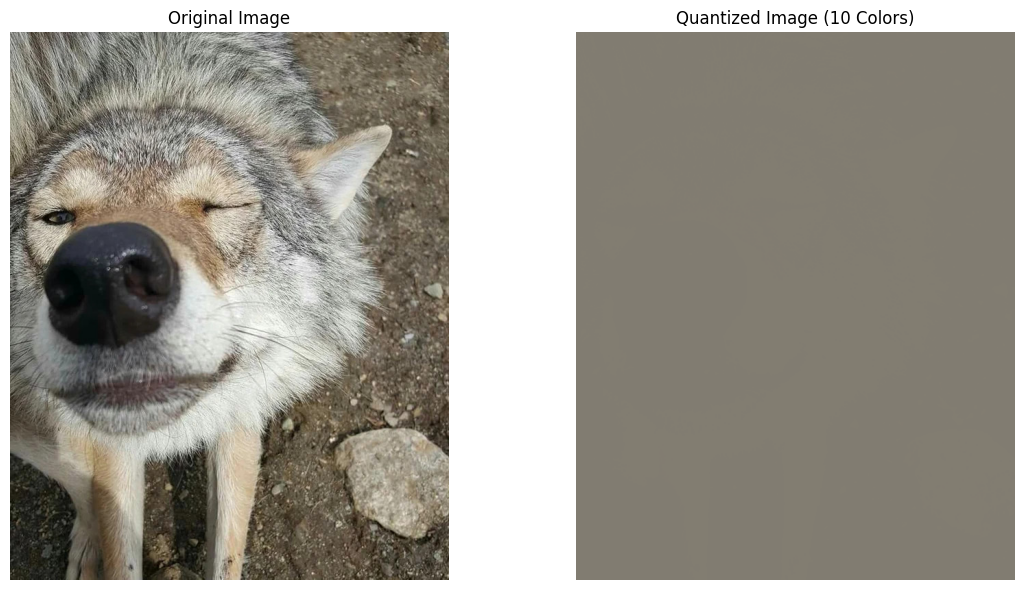

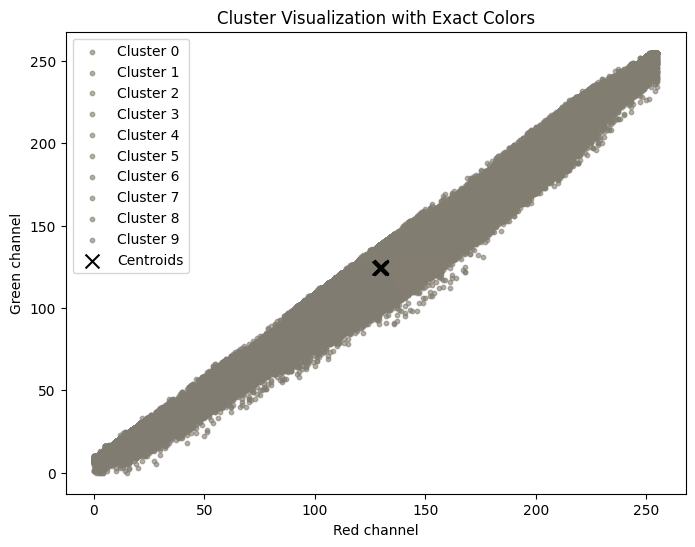

In [13]:
def main():
    # Image path
    image_path = '/content/wolf1.jpg'

    # Create image clustering instance
    image_clusterer = ImageClustering(
        # clustering_method=KMeans,    # Choose KMeans or FuzzyCMeans
        clustering_method=FuzzyCMeans,    # Choose KMeans or FuzzyCMeans
        n_clusters=10                     # Number of colors
    )

    try:
        print("Debugging!")

        # Perform color quantization
        original, quantized, centroids, labels, pixels = image_clusterer.quantize_image(image_path)

        # Visualize results and cluster colors in 2D space
        image_clusterer.visualize_results(original, quantized)
        image_clusterer.visualize_clusters(pixels, labels, centroids)

        # Optionally save quantized image
        image_clusterer.save_quantized_image(
            quantized,
            '/content/quantized_image.jpg'
        )


    except Exception as e:
        print(f"An error occurred: {e}")

# Run the main function
if __name__ == "__main__":
    main()